# ArtCategorizer

In this notebook, I will create a simple art classifier for Impressionism, Cubism, and Rennaisance artwork. Of course, there are many more cultures and time periods represented in the art world, but for this illustration I feel like these three will suffice. I will implement a pre-trained neural net to build a model, which a user can then query an image against to try and classify it into an artistic period. 

## Data

For a project such as this, there are many sources of publicly available images throughout the internet. For example, just going to Wikimedia Commons or simply using the image tab of a Google search. This allows the following method to be used to classify pretty much any image as long as someone is willing to curate the results and right click each image to save it. We will take advantage of a data set from Kaggle where the paintings have been sorted into art movements, [ArtSnob1](https://www.kaggle.com/parkerzmartin/artgenreset) (there is also an [ArtSnob2](https://www.kaggle.com/parkerzmartin/art-snobs-data2) is available to expand the categorization later on).

## Folder Structure

The folder structure for the code will be the following:

* ArtCategorizer  
    * data  
        * train
            * Impressionism
            * Realism
            * Romanticism
        * validation
            * Impressionism
            * Realism
            * Romanticism
    * models
    * artcategorizer.py
    * predict.py
    * requirements.txt
    
I am a big fan of not reinventing the wheel. A huge number of tutorials out there outline how to build a really nice image classifier, and on eof my favorites that I will base this off of is a [Predator-Alien classifier](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/) by Piotr Migdal, Patryk Miziuła and Rafał Jakubanis. I modified their code to handle the larger number of categories, but their preprocessing approach and use of ResNet-50 will suit this art classification quite well. **Res**idual **net**work-50 is a neural network **50** layers deep and trained on more than a million images. This model will leverage all of this pre-trained goodness, retaining the 50 convolutional layers while replacing the ~1000 existing classification layers with our new Impressionism, Realism, and Romanticism categorization. Afterwards I plan to build out a more interactive dashboard for future predictions.


## Modules

The modules used in this project are listed in the rquirements text file. To build the model we need:

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers

Using TensorFlow backend.


## Preprocess the images

Similar to the Predator-Alien classifier mentioned above, I will use the preprocessing conditions used in the [Keras documantation](https://keras.io/preprocessing/image/) in order to get the best use out of such a powerful pretrained neural net. I did adjust the image size to the Resnet-50 preferred 224x224. These preprocessing steps:

    1. alter the images slightly in order to make a more robust NN
    2. Resize the images to be consistent with the orignal images used to create the NN
    3. Load the images into the model in batches to circumvent any memory issues

In [3]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))


Found 385 images belonging to 3 classes.
Found 158 images belonging to 3 classes.


In [6]:
conv_base = ResNet50(include_top=False,
                     weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

## Train the model

In [8]:
print('training')
history = model.fit_generator(
    generator=train_generator,
    epochs=4,
    validation_data=validation_generator)


training
Epoch 1/4
13/13 [==============================] - 69s 5s/step - loss: 0.7514 - accuracy: 0.6987 - val_loss: 1.5576 - val_accuracy: 0.5443
Epoch 2/4
13/13 [==============================] - 74s 6s/step - loss: 0.6905 - accuracy: 0.7325 - val_loss: 2.2389 - val_accuracy: 0.5759
Epoch 3/4
13/13 [==============================] - 90s 7s/step - loss: 0.6416 - accuracy: 0.7584 - val_loss: 1.3304 - val_accuracy: 0.5696
Epoch 4/4
13/13 [==============================] - 82s 6s/step - loss: 0.5859 - accuracy: 0.7558 - val_loss: 1.7419 - val_accuracy: 0.5443


## Save the model

In [9]:
model.save('models/keras/model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
    f.write(model.to_json())

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model, model_from_json

In [12]:
print('load the model')
# architecture and weights from HDF5
model = load_model('models/keras/model.h5')

# architecture from JSON, weights from HDF5
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

load the model


predict


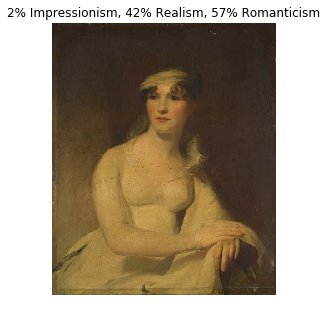

In [37]:
print('predict')
validation_img_paths = [#"data/validation/Impressionism/88929.jpg"]
                        "data/validation/Romanticism/46869.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

img_size = 224
validation_batch = np.stack([preprocess_input(np.array(img.resize((img_size, img_size))))
                             for img in img_list])

pred_probs = model.predict(validation_batch)


fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs#[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Impressionism, {:.0f}% Realism, {:.0f}% Romanticism".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1],
                                                          100*pred_probs[i,2]))
    ax.imshow(img)

## Radar Plot

I thought it might be neat to plot the prediction probabilities as a radar plot, which should end up being a sort of pointer towards the art movement with the highest probability. As Matplotlib does not have a built in code, Yan Holtz provides a nice snippet of code to plot the individual elements to create a [basic radar plot](https://python-graph-gallery.com/390-basic-radar-chart/). 

In [31]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

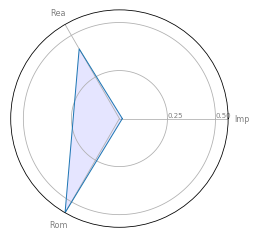

In [38]:
# Set data
max_pp = max([pred_probs[i,0], pred_probs[i,1], pred_probs[i,2]])

df = pd.DataFrame({
'group': ['A'],
'Imp': [pred_probs[i,0]],
'Rea': [pred_probs[i,1]],
'Rom': [pred_probs[i,2]]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.50,0.75], ["0.25","0.50","0.75"], color="grey", size=7)
plt.ylim(0,max_pp)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)
